# Anomaly Detection - Outliers

---
## Point anomalies on test responding

It is mainly important to analyze all the features involved in every test taken by a person, and it is straightforward thinking that not all tasks are with full concentration because the nature of the tool, is an app, and we might expect the people taking the test can get distracted by some random reason

The main objective here is to analyze any pattern related to the time in milliseconds a participant spend on responding every visual task.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
color_ms = '#386cb0' #blue, This is the color chosen for patients with Multiple Sclerosis
color_hc = 'red'#This is the color chosen for health control participants

In [3]:
df_measures_users = pd.read_csv('https://s3.eu-west-3.amazonaws.com/pedrohserrano-datasets/df_measures_users.csv', encoding="utf-8")

In [4]:
df_symbols = pd.read_csv('https://s3.eu-west-3.amazonaws.com/pedrohserrano-datasets/df_symbols.csv', encoding="utf-8") 

In [5]:
score_variable = 'correct.answers'

### Population of Study

In [6]:
print('{} Data points distribuited among {} Participants'.format(len(df_symbols), len(df_measures_users)))

11420 Data points distribuited among 23 Participants


We choose the score variable as the number of correct answers on every test

In [7]:
#Split the patients MS (Multiple Sclerosis) and HC (Health Control)
df_ms = df_measures_users[df_measures_users['ms']==1]
df_hc = df_measures_users[df_measures_users['ms']==0]

In [8]:
print('Patients on MS group: {} ({}%)\nPatients on HC group: {} ({}%) '.format(
        len(df_ms), round(len(df_ms)/len(df_measures_users)*100, 0),
        len(df_hc), round(len(df_hc)/len(df_measures_users)*100, 0)))

Patients on MS group: 15 (65.0%)
Patients on HC group: 8 (35.0%) 


Text(0.5,1,'Scores Distribution MS and HC Groups')

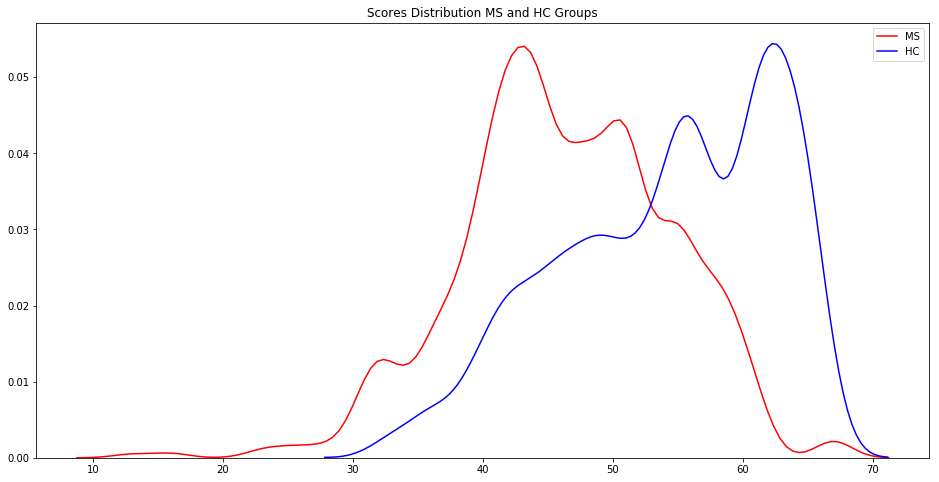

In [9]:
plt.figure(figsize=[16, 8])
sns.kdeplot(df_symbols[df_symbols['ms']==1][score_variable], color='red', label='MS')
sns.kdeplot(df_symbols[df_symbols['ms']==0][score_variable], color='blue', label='HC')
plt.title('Scores Distribution MS and HC Groups')

---
### Defining Boundary

The first thing we have to consider is the time.

So we define $ \Delta_{tr} $ as the time elapsed between 2 trials, where a trial is the event of push the buttom and select a digit on the test.

Thinking on this we say that every person perform $n$ number of tests and every test has $m$ number of trials, then the time elapsed to perform every trial is $ \Delta_{tr} $

We define $T$ as the vector of time responses on an event, following this logic we can calculate the median of those times.

Finally we may calculate the $SD$ of all the people on MS and Health Control grou separatelly

##### Distraction Points

$$ \Delta_{tr} > median(T) + 2 (SD (Group))  \hspace{1cm} $$
$$ \max{\{\Delta_{tr},0\}} < median(T) - 2 (SD (Group))  \hspace{1cm} \forall{\Delta_{tr}}$$

$T =(\Delta_{tr1}, \Delta_{tr2}, ... \Delta_{trm})$  
$tr =$ Time of response on a trial

In [10]:
print('Standart Deviation of every delta per group \n MS: {} \n HC: {}'.format(
df_symbols['response_ms_sd'].unique()[0], df_symbols['response_ms_sd'].unique()[1]))

Standart Deviation of every delta per group 
 MS: 663.6751885085198 
 HC: 502.5068924690813


### Detecting Outliers

We can just take one single event on a random choise person (eobt3CosDzEtxWW5P) for instance, and plot the time of response in milisecond alongside the 90 seconds showing the symbols choosen on each task

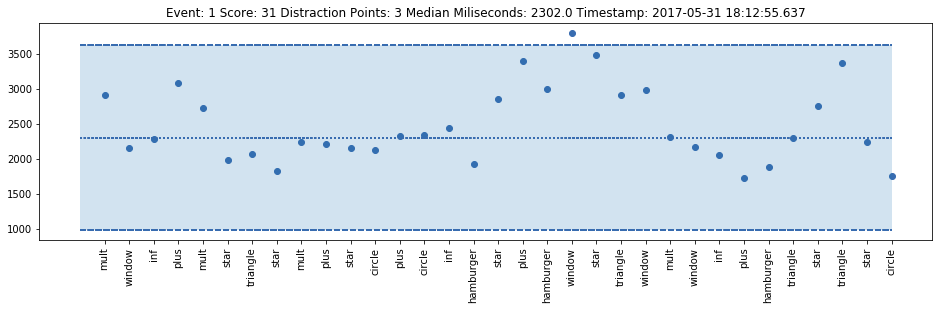

In [16]:
df_user = df_symbols[df_symbols['userId']=='eobt3CosDzEtxWW5P']
stamps = df_user['timestamp'].unique()

plt.figure(figsize=(16, 4))
df_user_ts = df_user[df_user['timestamp']==stamps[3]]
plt.scatter(df_user_ts['trial'], df_user_ts['response_ms'], color=color_ms)
plt.hlines(y=df_user_ts['sup_line'], xmin=0, xmax=max(df_user_ts['trial']), linestyles='--', color=color_ms)
plt.hlines(y=df_user_ts['inf_line'], xmin=0, xmax=max(df_user_ts['trial']), linestyles='--', color=color_ms)
plt.hlines(y=df_user_ts['response_ms_med'], xmin=0, xmax=max(df_user_ts['trial']), linestyles=':', color=color_ms)
plt.fill_between(range(len(df_user_ts['trial'])+1), df_user_ts['sup_line'].mean(), df_user_ts['inf_line'].mean(), alpha=0.2)
plt.xticks(df_user_ts['trial'], df_user_ts['symbol'], rotation=90)
grouped = df_symbols.groupby(['userId','timestamp'])['distract_points'].sum().reset_index()
d_point = grouped[(grouped['userId']=='eobt3CosDzEtxWW5P') & (grouped['timestamp']==stamps[0])]['distract_points'].values
plt.title('Event: 1 Score: '+str(max(df_user_ts['correct.answers']))+' Distraction Points: '+str(d_point[0])+' Median Miliseconds: '+str(df_user_ts['response_ms_med'].mean())+' Timestamp: '+str(stamps[0]))
plt.show()

As we might see the points outside of the boundaries are distraction points because they are 2 SD of the median time of response, where the SD corresponds the variance of the group.

The plot below shows the distribution of the time of response in milliseconds on this same event.

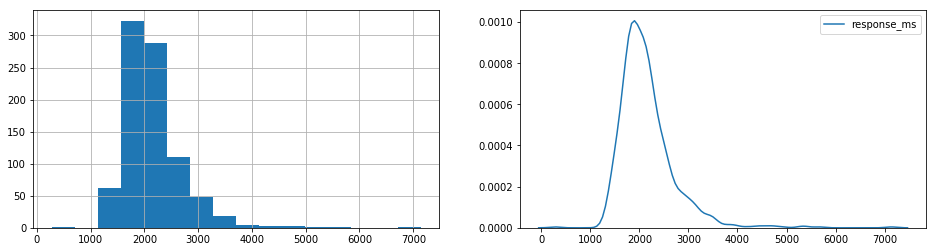

In [12]:
plt.figure(figsize=(16, 4))
plt.subplot(1,2,1)
df_user['response_ms'].hist(bins=16)
plt.subplot(1,2,2)
sns.kdeplot(df_user['response_ms'])

### Distraction Points Correlated

The first thing to check is the relation that distracting points have with the score performed on every individual, as we know each test has distraction points and scores, we might aggregate per groups, then we can compare if there is any difference between the number of distractions if a person is MS or HC

In [13]:
df_measures_users.groupby('ms').mean()

correct.answers  total.answers  accuracy.rate  avg_test_ms       hour  \
ms                                                                           
0.0        52.918429      53.447127       0.989380  3355.509615  14.208883   
1.0        46.223607      46.766710       0.986986  3827.878461  15.006200   

        events  correct.answers_median  distract_points  
ms                                                       
0.0   8.375000                 53.1875         1.811531  
1.0  11.933333                 46.6000         1.496902

The table below shows the distractions and scores on each group

| Group | Average Score | Average Distractions |
|:--:|:--:|:--:|
| MS | 52.91 | 1.81 |
| HC | 46.22 | 1.49 |

In [14]:
df_ms = df_measures_users[df_measures_users['ms']==1]
df_hc = df_measures_users[df_measures_users['ms']==0]

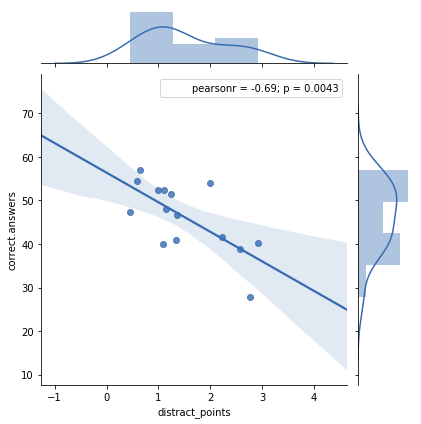

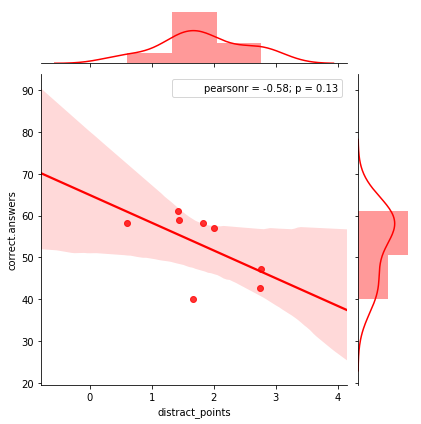

In [15]:
sns.jointplot("distract_points", "correct.answers", data=df_ms, kind="reg", color=color_ms) #MS correlation
sns.jointplot("distract_points", "correct.answers", data=df_hc, kind="reg", color=color_hc) #HC correlation

As we may see on the plots above we see a negative and significative correlation, the MS group is more clear.
**The more distractions the less score**

The number of distractions that a single person has is a clear feature that helps to classify the MS people, this feature does not deoend in demographic variables but just with in the test behaviour